In [39]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt

This model uses the Fashion MNIST, which is defined in this paper:
Xiao, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms (2017)
(link)[https://arxiv.org/abs/1708.07747]

In [40]:
# Download the training data from Keras
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [41]:
# Let's copy the labels defined in the paper:
fashion_labels = [
    "T-Shirt/Top", 
    "Trouser", 
    "Pullover", 
    "Dress", 
    "Coat", 
    "Sandals", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle boots"
]

In [42]:
# Let's see the shape of an image:
train_images[327].shape

(28, 28)

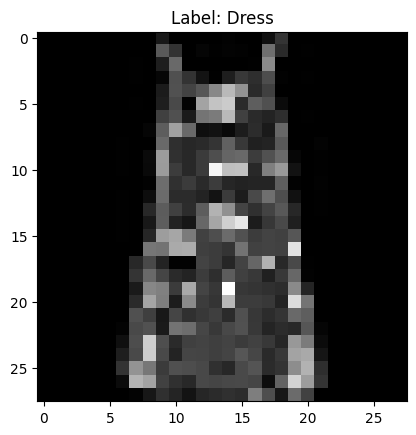

In [43]:
# Now let's plot the 327th sample to see what the raw image look like
plt.plot()
plt.title(f"Label: {fashion_labels[train_labels[327]]}")
plt.imshow((train_images[327]), cmap=plt.get_cmap('gray'))
plt.show()

In [44]:
# Let's verify it matches the 327th label!
fashion_labels[train_labels[327]]

'Dress'

In [45]:
# Pixel values are black & white, and between 0 and 255
train_images.min(), train_images.max()

(0, 255)

In [46]:
# Let's normalize their values to be between 0 and 1
train_images, test_images = train_images / 255, test_images / 255
# Checking normalization: we should be between 0 and 1
train_images.min(), train_images.max()

(0.0, 1.0)

In [47]:
train_n = train_images.shape[0]
test_n = test_images.shape[0]
train_n, test_n

(60000, 10000)

In [48]:
train_images = train_images.reshape((train_n, 28, 28, 1))
test_images = test_images.reshape((test_n, 28, 28, 1))
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [49]:
# Let's find unique values in the labels
import numpy as np

values, counts = np.unique(train_labels, return_counts=True)
nb_values = len(values)
nb_values, values, counts

(10,
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [50]:
# One-hot encoding of the labels (5 -> [0, 0, 0, 0, 0, 1, ...])
# cf. https://en.wikipedia.org/wiki/One-hot
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [51]:
# Let's verify that labels are the proper shape: a list of list
train_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [52]:
train_labels.shape

(60000, 10)

In [62]:
def define_conv_model(conv_size=32):
    model = models.Sequential()

    model.add(layers.Conv2D(conv_size, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(conv_size * 2, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(conv_size * 4, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(nb_values, activation='softmax'))

    return model

In [63]:
# Notes:
#   - the 'sparse_categorical_crossentropy' loss is only for labels using integers, not for encoded labels like ours
#   - we specify the optimizer instead of 'adam' to be able to change the learning rate
#   - no need to return anything, the model is modified "in-place" 
def compile_model(model, learning_rate=0.003):
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
# We parameterize the training so that parameters can be logged in MLFlow
def train_model(model, train_images, train_labels, epochs=3, batch_size=64, validation_split=0.2):
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

In [65]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Brief 13 - 2. Fashion MNIST")

<Experiment: artifact_location='mlflow-artifacts:/170645947334896060', creation_time=1709492309773, experiment_id='170645947334896060', last_update_time=1709492309773, lifecycle_stage='active', name='Brief 13 - 2. Fashion MNIST', tags={}>

In [66]:
import time

with mlflow.start_run():
    conv_size = 16
    learning_rate = 0.004
    epochs = 3
    batch_size = 64

    mlflow.log_param("conv_size", conv_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    
    model = define_conv_model(conv_size)
    compile_model(model, learning_rate)
    
    # We time only time the training part
    start_t = time.time()    
    train_model(model, train_images, train_labels, epochs, batch_size)
    end_t = time.time()

    # Evaluate the model on the test set
    loss, acc = model.evaluate(test_images, test_labels)
    print(f'Loss: {loss}, accuracy: {acc}')
    
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("training_duration", end_t - start_t)  

    # mlflow.tensorflow.save_model(model, "model_MNIST")
    # mlflow.log_artifacts("model_MNIST", artifact_path="models")

Epoch 1/3
750/750 [==============================] - 16s 20ms/step - loss: 0.5310 - accuracy: 0.8077 - val_loss: 0.4407 - val_accuracy: 0.8371
Epoch 2/3
750/750 [==============================] - 17s 23ms/step - loss: 0.4079 - accuracy: 0.8513 - val_loss: 0.3806 - val_accuracy: 0.8633
Epoch 3/3
313/313 [==============================] - 2s 5ms/step - loss: 0.4976 - accuracy: 0.7992
Loss: 0.4975699186325073, accuracy: 0.7991999983787537


In [67]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_12 (Ba  (None, 26, 26, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 batch_normalization_13 (Ba  (None, 11, 11, 32)        128       
 tchNormalization)                                               
                                                      